# Natural Computing Project: 
## Investigate how different combinations of crossover and mutation operators in a neuroevolution algorithm behave on different problems

This is the final notebook with the algorithm, plotting functions, data retrieval and example runs. The full runs can be found on Github but because we didn't want to lose data from long runs, those files became a bit messy.

We ran the XOR and MNIST examples with the function:
try_probs(x_train, y_train, x_test, y_test, gens, probabilities)
try_probs_mnist(x_train, y_train, x_test, y_test, gens, probabilities)

These functions call the neuroevolution algorithm with the nine different combinations.
The plot_probs2 function can be used to plot the results.

In [18]:
#First some imports 
import numpy as np
from copy import deepcopy
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

In [2]:
# Next, we define the activation functions. There is a choice between ReLU, Sigmoid and SoftMax
def ReLU(mat, gradient = False):
    if gradient:
        return mat * (mat > 0), 1 * (mat > 0)
    return mat * (mat > 0)

def Sigmoid(mat, gradient = False):
    sigm = 1/(1 + np.exp(-mat))
    if gradient:
        return sigm, sigm * (1 - sigm)
    return sigm

def SoftMax(mat, gradient = False):
    exp_mat = np.exp(mat - np.max(mat, axis = 1, keepdims = True))
    res_mat =  exp_mat/np.sum(exp_mat, axis = 1, keepdims = True)
    if gradient:
        return res_mat, res_mat * (1 - res_mat)
    return res_mat

In [5]:
# Next, we have a network class which contains the number of layer, activation function, weights, biases and current fitness.
# The forward function pushes the samples through the current network and returns the return values.
class Network:
    def __init__(self, node_seq, activation_functions, Xavier = True):
        self.node_seq = node_seq
        self.num_layers = len(node_seq) - 1
        self.activation = activation_functions
        self.weight_mats = []
        self.bias_vecs = []
        self.fitness = 0
        self.weight_mats_gradient = []
        self.bias_vecs_gradient = []
        for idx in range(self.num_layers):
            n_in = node_seq[idx]
            n_out = node_seq[idx + 1]
              # use Xavier initialization
            bound = np.sqrt(6/(n_in + n_out))
            if Xavier:
                self.weight_mats.append(np.random.uniform(-bound, bound, size = (n_in, n_out)))
            else: 
                self.weight_mats.append(np.zeros((n_in, n_out)))
            self.bias_vecs.append(np.zeros(n_out))
            self.weight_mats_gradient.append(np.zeros((n_in, n_out)))
            self.bias_vecs_gradient.append(np.zeros(n_out))
            
            
    def forward(self, samples, gradient = False):
        # note: give inputs in the form (samples, features)
        if not gradient:
            for idx in range(self.num_layers):
                samples = self.activation[idx](samples @ self.weight_mats[idx] + self.bias_vecs[idx])
            return samples
    
        n_samples = samples.shape[0]
        sample_list = [samples]
        current_sample = samples
        gradient_list = []
        layer_gradient = []
          
          # forward step
        for idx in range(self.num_layers):
            current_sample, current_gradient = self.activation[idx](current_sample @ 
                     self.weight_mats[idx] + self.bias_vecs[idx], gradient = True)
            gradient_list.append(current_gradient)
            sample_list.append(current_sample)
            n_in = self.node_seq[idx]
            n_out = self.node_seq[idx + 1]
            layer_gradient.append(np.zeros((n_samples, n_in)))
        
          # backward step
        layer_gradient.append(2*sample_list[self.num_layers])
        for idx in range(self.num_layers - 1, -1, -1):
            self.weight_mats_gradient[idx] = sample_list[idx].T @ layer_gradient[idx + 1]
            self.bias_vecs_gradient[idx] = np.ones(n_samples).T @ layer_gradient[idx + 1]
            layer_gradient[idx] = (layer_gradient[idx + 1] * gradient_list[idx]) @ self.weight_mats[idx].T 
        
        return current_sample
        
        
net = Network([2,2,2], [ReLU, SoftMax])
net.forward(np.array([[0,0], [0,1], [1,0], [1,1]]), True)
        
# small example on how to use network and forwards        
net = Network([2,2,2], [ReLU, SoftMax])
net.forward(np.array([[0,0], [0,1], [1,0], [1,1]]), True)

array([[0.5       , 0.5       ],
       [0.31836204, 0.68163796],
       [0.49502544, 0.50497456],
       [0.31405952, 0.68594048]])

In [24]:
# This block defines several fitness functions
def cross_entropy_fitness(correct, predict):
    return max(np.sum(np.log(predict[range(predict.shape[0]), correct])) + predict.shape[0], 0)

  # computes fitness based on xor of all binary sequences of a given length
def xor_fitness(net, inputs, outputs, gradient = False):
    predict = net.forward(inputs, gradient)
    return cross_entropy_fitness(outputs, predict)

def xor_all_fitness(net, inputs, outputs, gradient = False):
    predict = net.forward(inputs, gradient)
    return np.log(predict[range(predict.shape[0]), outputs])

def xor_acc(net, inputs, outputs):
    predict = net.forward(inputs)
    return sum([outputs[i]==np.argmax(predict[i]) for i in range(0, len(outputs))])/len(predict)

def mnist_fitness(net, inputs, outputs, gradient = False):
    predict = net.forward(inputs, gradient)
    return sum([outputs[i]==np.argmax(predict[i]) for i in range(0, len(outputs))])/len(predict)

def cross_entropy_fitness_mnist(correct, predict):
    return max(np.sum(np.log(predict[range(predict.shape[0]), correct]))/4 + predict.shape[0], 0)

In [7]:
# This block contains the different crossover and mutation operators
def crossover_minimax(net1, net2):
    node_seq = net1.node_seq
    activation = net1.activation
    new_net1 = Network(node_seq, activation, Xavier = False)
    new_net2 = Network(node_seq, activation, Xavier = False)
    for idx in range(net1.num_layers): #perhaps random choice, instead of one net all minima and one net all maxima
        new_net1.weight_mats[idx] = np.minimum(net1.weight_mats[idx], net2.weight_mats[idx])
        new_net2.weight_mats[idx] = np.maximum(net1.weight_mats[idx], net2.weight_mats[idx])
        new_net1.bias_vecs[idx] = np.minimum(net1.bias_vecs[idx], net2.bias_vecs[idx])
        new_net2.bias_vecs[idx] = np.maximum(net1.bias_vecs[idx], net2.bias_vecs[idx])
    return new_net1, new_net2
    
def crossover_layer(net1, net2):
    node_seq = net1.node_seq
    activation = net1.activation
    new_net1 = Network(node_seq, activation, Xavier = False)
    new_net2 = Network(node_seq, activation, Xavier = False)
    select_layers = np.random.uniform(size = net1.num_layers)
    for idx in range(net1.num_layers): 
        if select_layers[idx] < 0.5:
            new_net1.weight_mats[idx] = net1.weight_mats[idx]
            new_net2.weight_mats[idx] = net2.weight_mats[idx]
            new_net1.bias_vecs[idx] = net1.bias_vecs[idx]
            new_net2.bias_vecs[idx] = net2.bias_vecs[idx]
        else:
            new_net1.weight_mats[idx] = net2.weight_mats[idx]
            new_net2.weight_mats[idx] = net1.weight_mats[idx]
            new_net1.bias_vecs[idx] = net2.bias_vecs[idx]
            new_net2.bias_vecs[idx] = net1.bias_vecs[idx]
    return new_net1, new_net2
    
def mut_layer(net, gradient = False):
    mut_size = np.random.uniform()
    select_layers = np.random.uniform(size = net.num_layers)
    for idx in range(net.num_layers): 
        if select_layers[idx] < 0.5:
            n_in = net.node_seq[idx]
            n_out = net.node_seq[idx + 1]
            bound = np.sqrt(6/(n_in + n_out)) * mut_size
            if gradient:
                net.weight_mats[idx] += np.random.uniform(-mut_size, mut_size, \
                     size = (n_in, n_out)) / np.sqrt(np.maximum(np.abs(net.weight_mats_gradient[idx]), 0.01))
                net.bias_vecs[idx] += np.random.uniform(-mut_size, mut_size, \
                     size = n_out) /  np.sqrt(np.maximum(np.abs(net.bias_vecs_gradient[idx]), 0.01))
            else:
                bound = np.sqrt(6/(n_in + n_out)) * mut_size
                net.weight_mats[idx] += np.random.uniform(-bound, bound, size = (n_in, n_out))
                net.bias_vecs[idx] += np.random.uniform(-bound, bound, size = n_out)

def mut_index(net, gradient = False):
    mut_size = np.random.uniform()
    idx = int(np.random.choice(net.num_layers, 1))
    n_in = net.node_seq[idx]
    n_out = net.node_seq[idx + 1]
    idx2 = int(np.random.choice(n_in, 1))
    idx3 = int(np.random.choice(n_out, 1))
    if gradient:
        net.weight_mats[idx][idx2][idx3] += np.random.uniform(-mut_size, mut_size, \
            size = 1) / np.sqrt(np.maximum(np.abs(net.weight_mats_gradient[idx][idx2][idx3]), 0.01))
    else:
        bound = np.sqrt(6/(n_in + n_out)) * mut_size
        net.weight_mats[idx][idx2][idx3] += np.random.uniform(-bound, bound, size = 1)


In [8]:
# The Genetic class defines the neuroevolution algorithm
class Genetic:
    def __init__(self, pop_size, node_seq, activation_functions, fitness_function, 
                 inp, outp, test_inp, test_outp, mutation_functions, mutation_probabilities, 
                 crossover_functions, crossover_probabilities, elite, gradient = False, max_fitness = np.inf):
        self.net_list = []
        self.pop_size = pop_size
        for idx in range(pop_size):
            self.net_list.append(Network(node_seq, activation_functions))
        
        self.fitness_func = fitness_function
        self.inp = inp
        self.outp = outp
        self.test_inp = test_inp
        self.test_outp = test_outp
        self.grad = gradient
        self.mutation_func = mutation_functions
        self.mutation_threshold = np.cumsum(mutation_probabilities)
        self.crossover_func = crossover_functions
        self.crossover_threshold = np.cumsum(crossover_probabilities)
        self.elite = elite
        self.current_best_fitness = 0
        self.max_fitness = max_fitness
        self.hist = []
        self.full_hist = []
        self.test_hist = []
        self.test_full_hist = []
        
    def next_generation(self):
        if self.current_best_fitness + 0.001 > self.max_fitness:
            pass # continuing to evolve (near-)optimal solutions can lead to instability
        
        new_net_idx = np.random.permutation(self.pop_size)
        new_net_list = [deepcopy(self.net_list[idx]) for idx in new_net_idx]
        
        select_mutate = np.random.uniform(size=self.pop_size)
        for idx in range(self.pop_size):
            for mut_idx in range(len(self.mutation_func)):
                  # select mutation mut_idx if self.mutation_threshold[mut_idx-1] <
                  # select_mutate[idx] < self.mutation_threshold[mut_idx]
                if select_mutate[idx] < self.mutation_threshold[mut_idx]:
                    self.mutation_func[mut_idx](new_net_list[idx], self.grad)
                    break 
                    
        cross_net_idx = np.random.permutation(self.pop_size)
        cross_net_list = [deepcopy(self.net_list[idx]) for idx in cross_net_idx]
        select_cross = np.random.uniform(size = self.pop_size)
        for idx in range(self.pop_size//2):
            for cross_idx in range(len(self.crossover_func)):
                if select_cross[idx] < self.crossover_threshold[cross_idx]:
                    cross_net_list[2*idx], cross_net_list[2*idx + 1] =  \
                      self.crossover_func[cross_idx](cross_net_list[2*idx], \
                                                     cross_net_list[2*idx + 1])
                    
        new_net_list.extend(cross_net_list)
        new_net_list.extend(self.net_list)
        for net in new_net_list:
            net.fitness = self.fitness_func(net, self.inp, self.outp, self.grad)
            net.test_fitness = self.fitness_func(net, self.test_inp, self.test_outp, self.grad)
        
        test_fitnesses = [net.test_fitness for net in new_net_list]
        self.test_hist.append(max(test_fitnesses))
        self.test_full_hist.append(test_fitnesses)
        
        new_net_list.sort(key = lambda x: -x.fitness)
        fitnesses = [net.fitness for net in new_net_list]
        probabilities = fitnesses / np.sum(fitnesses)
        net_idx = np.random.choice(len(new_net_list), self.pop_size - self.elite, p = probabilities)
        self.net_list = [new_net_list[idx] for idx in net_idx]
        self.net_list.extend(new_net_list[:self.elite])

        self.net_list.sort(key = lambda x: -x.fitness)
        if self.net_list[0].fitness > 0.0001 + self.current_best_fitness:
            self.current_best_fitness = self.net_list[0].fitness
        self.hist.append(self.net_list[0].fitness)
        self.full_hist.append([i.fitness for i in self.net_list])

# XOR

In [9]:
# Different lengths input
# LENGTH 2
seq_len = 2
X2 = [[(num >> idx) % 2 for idx in range(seq_len)] for num in range(2**seq_len)]
y2 = [sum(seq) % 2 for seq in X2]
X2_train, X2_test, y2_train, y2_test = model_selection.train_test_split(X2, y2, test_size=0.33, random_state=42, shuffle=True)

# LENGTH 4
seq_len = 4
X4 = [[(num >> idx) % 2 for idx in range(seq_len)] for num in range(2**seq_len)]
y4 = [sum(seq) % 2 for seq in X4]
X4_train, X4_test, y4_train, y4_test = model_selection.train_test_split(X4, y4, test_size=0.33, random_state=42, shuffle=True)

# LENGTH 8
seq_len = 6
X6 = [[(num >> idx) % 2 for idx in range(seq_len)] for num in range(2**seq_len)]
y6 = [sum(seq) % 2 for seq in X6]
X6_train, X6_test, y6_train, y6_test = model_selection.train_test_split(X6, y6, test_size=0.33, random_state=42, shuffle=True)

In [10]:
probabilities = [
    ([1, 0, 1, 0], "mut_layer + cross_minimax"),
    ([1, 0, 0, 1], "mut_layer + cross_layer"),
    ([1, 0, 0.5, 0.5], "mut_layer + both cross"),
    ([0, 1, 1, 0], "mut_index + cross_minimax"),
    ([0, 1, 0, 1], "mut_index + cross_layer"),
    ([0, 1, 0.5, 0.5], "mut_index + both cross"),
    ([0.5, 0.5, 1, 0], "both mut + cross_minimax"),
    ([0.5, 0.5, 0, 1], "both mut + cross_layer"),
    ([0.5, 0.5, 0.5, 0.5], "all active")
]

In [15]:
def run_algo_xor(seq_len, x_train, y_train, x_test, y_test, nr_of_gens, prob):
    fitness_sum = []
    full_hist_sum = []
    test_fitness_sum = []
    test_full_hist_sum = [] 
    opt_nets = []
    for i in range(0, 10) :
        genetic_algo = Genetic(50, [seq_len, seq_len, 2], [ReLU, SoftMax], xor_fitness, 
                            x_train, y_train, x_test, y_test,
                            [mut_layer, mut_index], [prob[0], prob[1]], 
                            [crossover_minimax, crossover_layer], [prob[2], prob[3]], 1, gradient = False) 
                            #gradient can be set to True
        for gen in range(nr_of_gens):
            genetic_algo.next_generation()
        opt_net = genetic_algo.net_list[0]
        xor_all_fitness(opt_net, x_test, y_test)
        fitness_sum.append(genetic_algo.hist)
        full_hist_sum.append(genetic_algo.full_hist)
        test_fitness_sum.append(genetic_algo.test_hist)
        test_full_hist_sum.append(genetic_algo.test_full_hist)
        opt_nets.append(opt_net)
    return fitness_sum, full_hist_sum, test_fitness_sum, test_full_hist_sum, opt_nets
    
def try_probs(seq_len, x_train, y_train, x_test, y_test, nr_of_gens, probs):
    all_hists = []
    for (p, label) in probs:
        fitness_sum, full_hist_sum, test_fitness_sum, test_full_hist_sum, opt_nets = \
            run_algo_xor(seq_len, x_train, y_train, x_test, y_test, nr_of_gens, p)
        all_hists.append((fitness_sum, full_hist_sum, test_fitness_sum, test_full_hist_sum, label, opt_nets))
    return all_hists
    
def plot_probs2(nr_of_gens, all_hists):
    fig = plt.figure(figsize=(20,30))
    for i in range(0, 9):
        full_hist = np.array(all_hists[i][1]) #shape = (10, #gens, #pop)
        fitness = np.mean(np.array(all_hists[i][0]), axis = 0) #shape = (10, #gens)

        label = all_hists[i][4]

          # mean over the population, and over the 10 runs:
        mean = np.mean(np.mean(full_hist, axis = 2), axis = 0)
          # mean over the std of the population
        std = np.mean(np.std(full_hist, axis = 2), axis = 0)

        plt.subplot(5, 2, i+1)
        # plt.rcParams["figure.figsize"] = (15,8)
        plt.plot(range(0,nr_of_gens), fitness, label="Max fitness")
        #plt.plot(range(0,nr_of_gens), [min(i) for i in full_hist], label="Min fitness")
        plt.plot(range(0,nr_of_gens), mean, label="Mean fitness")
        plt.fill_between(range(0,nr_of_gens), mean-std, mean+std, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848', label="Std around mean")
        plt.xlabel("Generation")
        plt.ylabel("Fitness")
        #plt.legend()
        plt.title(label)
    plt.show()

In [16]:
# example run, sequence length 6 with 10 generations and all probability options
all_hists6 = try_probs(6, np.array(X6_train), np.array(y6_train), np.array(X6_test), np.array(y6_test), 10, probabilities)

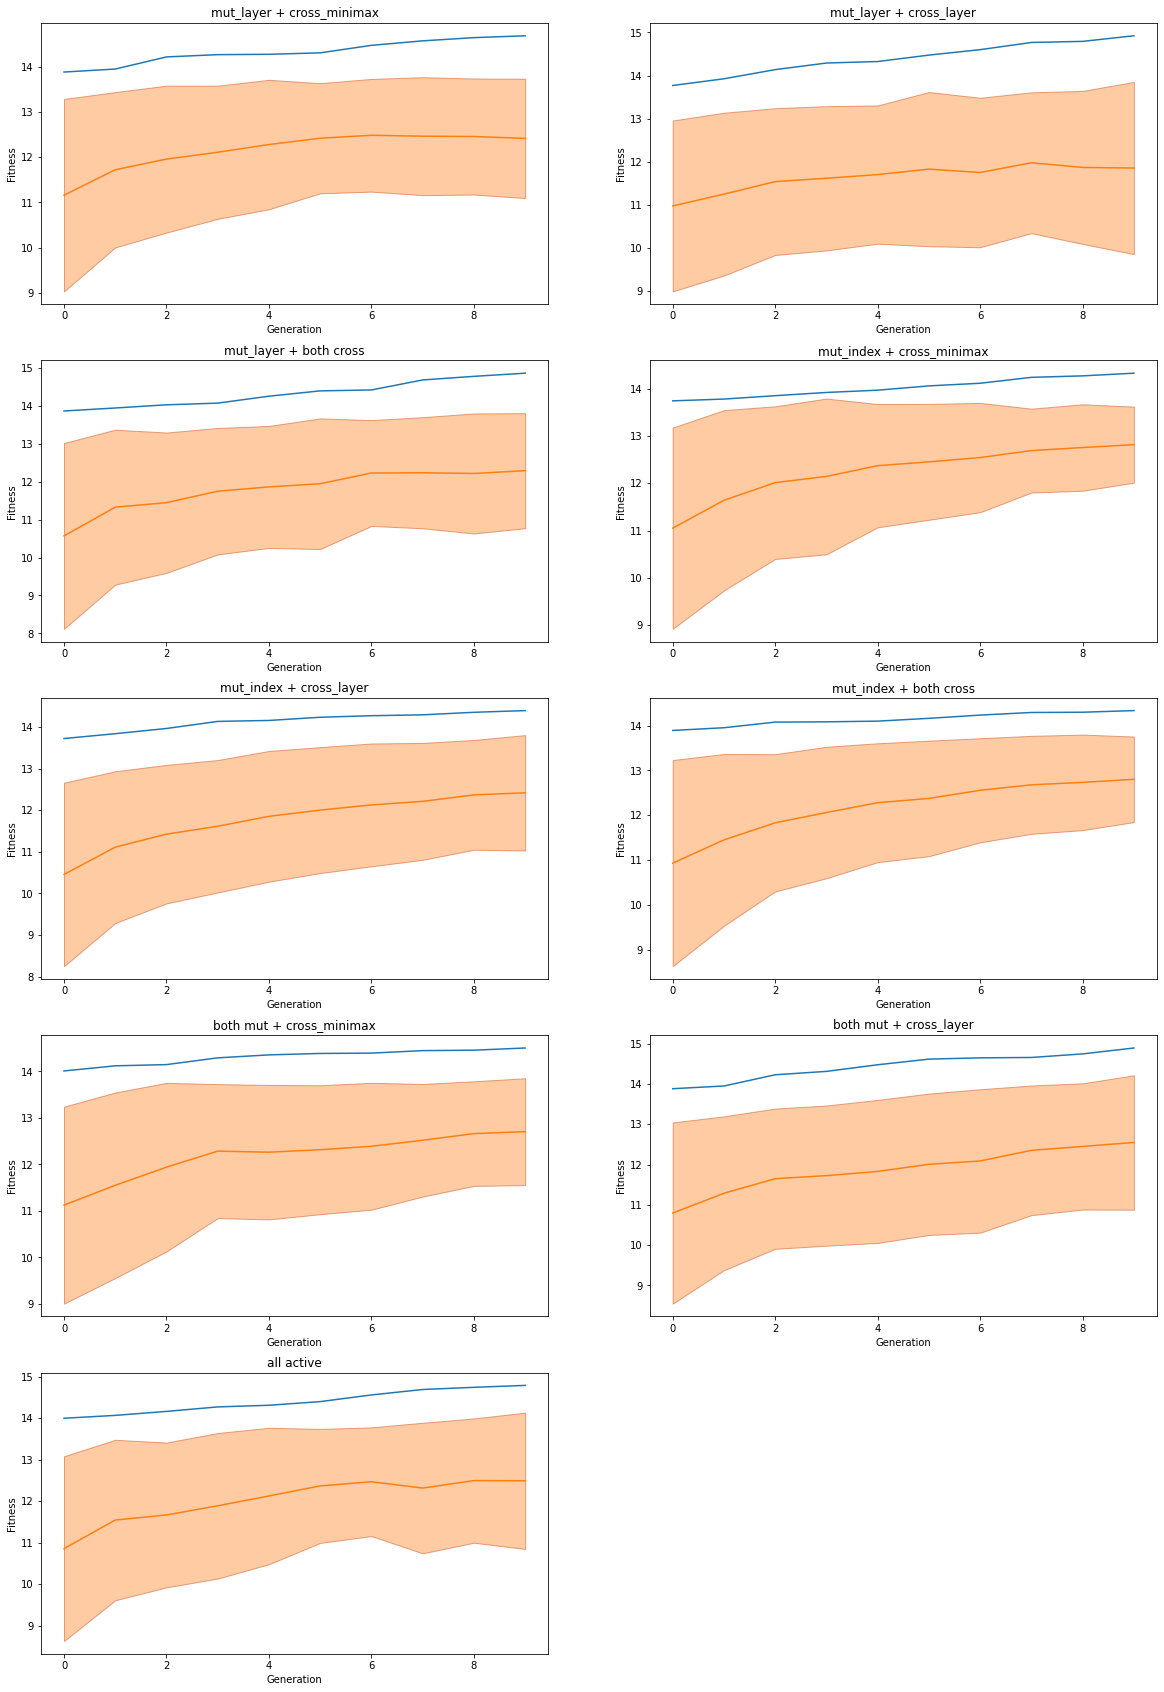

In [17]:
plot_probs2(10, all_hists6)

# MNIST

In [19]:
mnist = load_digits()
x_train, x_test, y_train, y_test = model_selection.train_test_split(mnist.data, mnist.target, test_size=0.33, random_state=42)

In [25]:
def run_algo_mnist(x_train, y_train, x_test, y_test, nr_of_gens, prob):
    fitness_sum = []
    full_hist_sum = []
    test_fitness_sum = []
    test_full_hist_sum = [] 
    opt_nets = []
    for i in range(0, 10) :
        genetic_algo = Genetic(20, [64, 20, 10], [ReLU, SoftMax], mnist_fitness, 
                            x_train, y_train,
                            x_test, y_test,
                            [mut_layer, mut_index], [prob[0], prob[1]], 
                            [crossover_minimax, crossover_layer], [prob[2], prob[3]], 1, gradient = False)
        for gen in range(nr_of_gens):
            genetic_algo.next_generation()
        opt_net = genetic_algo.net_list[0]
        xor_all_fitness(opt_net, x_test, y_test)
        fitness_sum.append(genetic_algo.hist)
        full_hist_sum.append(genetic_algo.full_hist)
        test_fitness_sum.append(genetic_algo.test_hist)
        test_full_hist_sum.append(genetic_algo.test_full_hist)
        opt_nets.append(opt_net)
    return fitness_sum, full_hist_sum, test_fitness_sum, test_full_hist_sum, opt_nets

def run_algo_mnist_true(x_train, y_train, x_test, y_test, nr_of_gens, prob):
    fitness_sum = []
    full_hist_sum = []
    test_fitness_sum = []
    test_full_hist_sum = [] 
    opt_nets = []
    for i in range(0, 10) :
        genetic_algo = Genetic(20, [64, 20, 10], [ReLU, SoftMax], mnist_fitness, 
                            x_train, y_train,
                            x_test, y_test,
                            [mut_layer, mut_index], [prob[0], prob[1]], 
                            [crossover_minimax, crossover_layer], [prob[2], prob[3]], 1, gradient = True)
        for gen in range(nr_of_gens):
            genetic_algo.next_generation()
        opt_net = genetic_algo.net_list[0]
        xor_all_fitness(opt_net, x_test, y_test)
        fitness_sum.append(genetic_algo.hist)
        full_hist_sum.append(genetic_algo.full_hist)
        test_fitness_sum.append(genetic_algo.test_hist)
        test_full_hist_sum.append(genetic_algo.test_full_hist)
        opt_nets.append(opt_net)
    return fitness_sum, full_hist_sum, test_fitness_sum, test_full_hist_sum, opt_nets

    
def try_probs_mnist(x_train, y_train, x_test, y_test, nr_of_gens, probs):
    all_hists = []
    for (p, label) in probs:
        fitness_sum, full_hist_sum, test_fitness_sum, test_full_hist_sum, opt_nets = run_algo_mnist(x_train, y_train, x_test, y_test, nr_of_gens, p)
        all_hists.append((fitness_sum, full_hist_sum, test_fitness_sum, test_full_hist_sum, label, opt_nets))
    return all_hists

def try_probs_mnist_true(x_train, y_train, x_test, y_test, nr_of_gens, probs):
    all_hists = []
    for (p, label) in probs:
        fitness_sum, full_hist_sum, test_fitness_sum, test_full_hist_sum, opt_nets = run_algo_mnist_true(x_train, y_train, x_test, y_test, nr_of_gens, p)
        all_hists.append((fitness_sum, full_hist_sum, test_fitness_sum, test_full_hist_sum, label, opt_nets))
    return all_hists
        
def plot_probs(nr_of_gens, all_hists):
    plt.rcParams["figure.figsize"] = (15,8)
    for (fitness, label) in all_hists:
        plt.plot(range(0,nr_of_gens), fitness[:nr_of_gens], label = label)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend()
    plt.title("Performance of the neuroevolution algorithm with different crossover / mutation probabilities.")
    plt.show()
    
def plot_probs2(nr_of_gens, all_hists):
    fig = plt.figure(figsize=(20,50))
    for i in range(0, 9):
        full_hist = all_hists[i][1][0]
        fitness = all_hists[i][0][0]
        test_full_hist = all_hists[i][3][0]
        test_fitness = [max(i) for i in test_full_hist] #min(all_hists[i][2][0]
        label = all_hists[i][4]
        mean = np.array([np.mean(i) for i in full_hist])
        std = np.array([np.std(i) for i in full_hist])
        test_mean = np.array([np.mean(i) for i in test_full_hist])
        test_std = np.array([np.std(i) for i in test_full_hist])

        plt.subplot(9, 2, i*2+1)
        # plt.rcParams["figure.figsize"] = (15,8)
        plt.plot(range(0,nr_of_gens), fitness, label="Max fitness")
        #plt.plot(range(0,nr_of_gens), [min(i) for i in full_hist], label="Min fitness")
        plt.plot(range(0,nr_of_gens), mean, label="Mean fitness")
        plt.fill_between(range(0,nr_of_gens), mean-std, mean+std, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848', label="Std around mean")
        plt.xlabel("Generation")
        plt.ylabel("Fitness")
        plt.legend()
        plt.title(label + " train")
        
        plt.subplot(9, 2, i*2+2)
        # plt.rcParams["figure.figsize"] = (15,8)
        plt.plot(range(0,nr_of_gens), test_fitness, label="Max fitness test loss", color="green")
        #plt.plot(range(0,nr_of_gens), [min(i) for i in full_hist], label="Min fitness")
        plt.plot(range(0,nr_of_gens), test_mean, label="Mean fitness test loss", color="purple")
        plt.fill_between(range(0,nr_of_gens), (test_mean-test_std), (test_mean+test_std), alpha=0.5, edgecolor='#F542D7', facecolor='#F77CE3', label="Std around mean test loss")
        plt.xlabel("Generation")
        plt.ylabel("Loss")
        plt.legend()
        plt.title(label + " test")
    plt.show()

In [27]:
all_hists_mnist = try_probs_mnist(x_train, y_train, x_test, y_test, 5, probabilities)

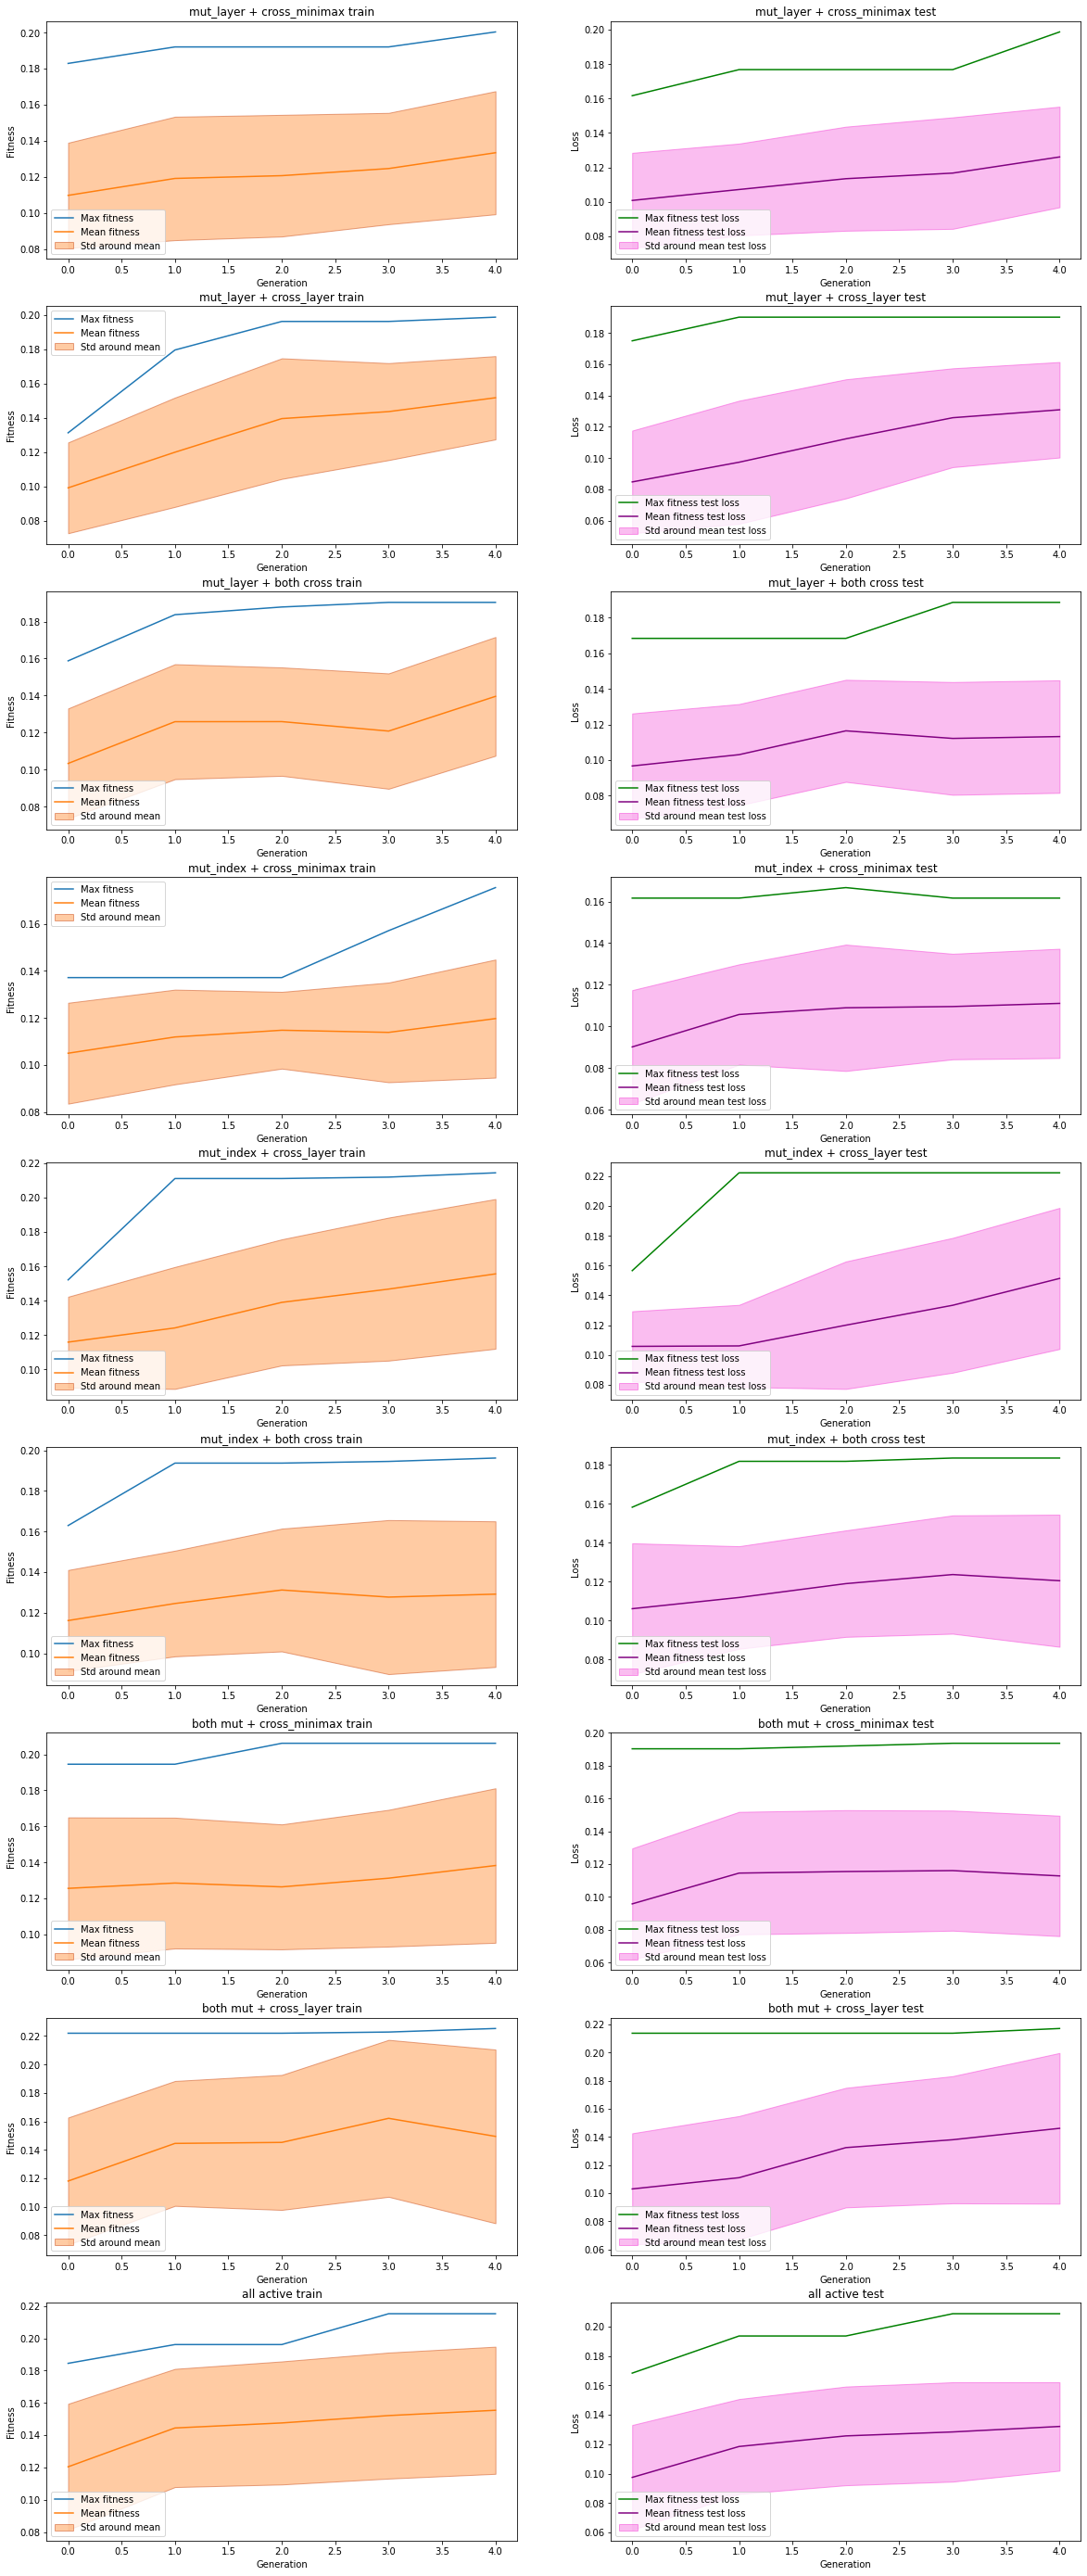

In [28]:
plot_probs2(5, all_hists_mnist)